In [11]:
import numpy as np
import gymnasium as gym
from blackjack import BlackjackEnv 
import matplotlib.pyplot as plt

def state_to_key(state):
    """
    Recursively convert state to a hashable tuple.
    This handles nested lists, tuples, and numpy arrays.
    """
    if isinstance(state, np.ndarray):
        return tuple(state.tolist())
    elif isinstance(state, (list, tuple)):
        return tuple(state_to_key(s) for s in state)
    else:
        return state

def choose_action(state, Q, n_actions, epsilon):
    """
    Chooses an action using an epsilon-greedy policy.
    Initializes unseen states in Q with zeros.
    """
    if state not in Q:
        Q[state] = np.zeros(n_actions)
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(Q[state])

def run_training(epsilon, num_train_episodes, alpha, gamma):
    """
    Runs Q-learning training on the Blackjack environment.
    
    Returns:
        Q - the learned Q-table (dictionary)
        training_rewards - list with the total reward per episode during training
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    Q = {}
    training_rewards = []

    print(f"\nStarting training: {num_train_episodes} episodes, epsilon={epsilon}")
    for episode in range(num_train_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        episode_reward = 0.0
        done = False

        while not done:
            action = choose_action(state, Q, n_actions, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = state_to_key(next_obs)
            
            # Initialize Q-values for unseen states
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            if next_state not in Q:
                Q[next_state] = np.zeros(n_actions)
            
            # Q-learning update
            old_value = Q[state][action]
            next_max = np.max(Q[next_state])
            Q[state][action] = old_value + alpha * (reward + gamma * next_max - old_value)
            
            state = next_state
            episode_reward += reward

        training_rewards.append(episode_reward)

        # Print progress at 10% intervals.
        if (episode + 1) % (num_train_episodes // 10) == 0:
            print(f"  Episode {episode + 1}/{num_train_episodes} completed.")

    env.close()
    return Q, training_rewards

def evaluate_policy(Q, num_eval_episodes):
    """
    Evaluates the learned policy (greedy with respect to Q) over a number of episodes.
    
    Returns:
        avg_reward - average reward per episode,
        win_rate   - percentage of episodes with a win,
        bust_count, push_count, loss_count - counts for the different outcomes.
    """
    env = BlackjackEnv(render_mode=None, natural=False, sab=False)
    n_actions = env.action_space.n
    total_reward = 0.0
    win_count = 0
    bust_count = 0
    push_count = 0
    loss_count = 0

    for _ in range(num_eval_episodes):
        obs, info = env.reset()
        state = state_to_key(obs)
        done = False
        episode_reward = 0.0

        while not done:
            # Use greedy action (epsilon = 0) during evaluation.
            if state not in Q:
                Q[state] = np.zeros(n_actions)
            action = np.argmax(Q[state])
            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = state_to_key(next_obs)
            done = terminated or truncated

        total_reward += episode_reward

        # Determine outcome based on reward and whether the hand is bust.
        # (This uses the environment's is_bust() method and current_hand.)
        if env.is_bust(env.current_hand):
            bust_count += 1
        elif episode_reward > 0.0:
            win_count += 1
        elif episode_reward == 0.0:
            push_count += 1
        elif episode_reward < 0.0:
            loss_count += 1

    env.close()
    avg_reward = total_reward / num_eval_episodes
    win_rate = win_count / num_eval_episodes * 100
    return avg_reward, win_rate, bust_count, push_count, loss_count


Starting training: 100000 episodes, epsilon=0.6
  Episode 10000/100000 completed.
  Episode 20000/100000 completed.
  Episode 30000/100000 completed.
  Episode 40000/100000 completed.
  Episode 50000/100000 completed.
  Episode 60000/100000 completed.
  Episode 70000/100000 completed.
  Episode 80000/100000 completed.
  Episode 90000/100000 completed.
  Episode 100000/100000 completed.


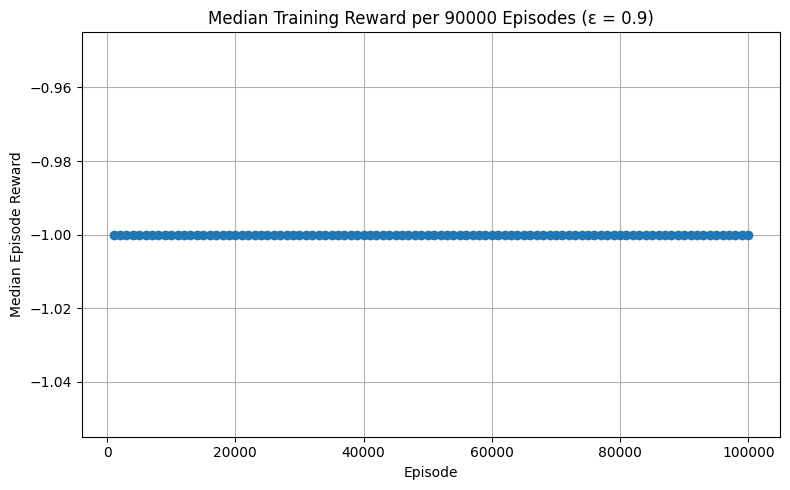

In [20]:

# Q-learning hyperparameters
alpha = 0.01       # Learning rate
gamma = 1.0        # Discount factor
num_eval_episodes = 10000  # Number of episodes for evaluation

### Experiment 1: Plot training reward (averaged every 1000 episodes) with ε = 0.9
epsilon_fixed = 0.6
num_train_episodes_exp1 = 100000
Q1, training_rewards = run_training(epsilon_fixed, num_train_episodes_exp1, alpha, gamma)

# Compute average reward for every block of 1000 episodes.
block_size = 1000
num_blocks = num_train_episodes_exp1 // block_size
block_avg_rewards = []
block_episodes = []
for i in range(num_blocks):
    start = i * block_size
    end = start + block_size
    avg_reward_block = np.median(training_rewards[start:end])
    block_avg_rewards.append(avg_reward_block)
    block_episodes.append(end)

plt.figure(figsize=(8, 5))
plt.plot(block_episodes, block_avg_rewards, linestyle='-', marker='o')
plt.title("Median Training Reward per 90000 Episodes (ε = 0.9)")
plt.xlabel("Episode")
plt.ylabel("Median Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Experiment 2: Varying epsilon to record win rate.

Training with epsilon = 0.00

Starting training: 900000 episodes, epsilon=0.0
  Episode 90000/900000 completed.
  Episode 180000/900000 completed.
  Episode 270000/900000 completed.
  Episode 360000/900000 completed.
  Episode 450000/900000 completed.
  Episode 540000/900000 completed.
  Episode 630000/900000 completed.
  Episode 720000/900000 completed.
  Episode 810000/900000 completed.
  Episode 900000/900000 completed.

Training with epsilon = 0.05

Starting training: 900000 episodes, epsilon=0.05263157894736842
  Episode 90000/900000 completed.
  Episode 180000/900000 completed.
  Episode 270000/900000 completed.
  Episode 360000/900000 completed.
  Episode 450000/900000 completed.
  Episode 540000/900000 completed.
  Episode 630000/900000 completed.
  Episode 720000/900000 completed.
  Episode 810000/900000 completed.
  Episode 900000/900000 completed.

Training with epsilon = 0.11

Starting training: 900000 episodes, e

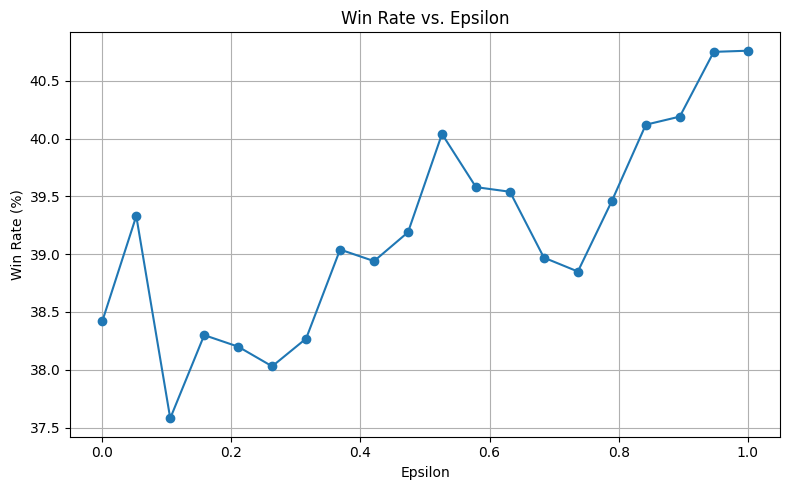

In [18]:
### Experiment 2: Plot win rate versus different epsilon values
# Use 20 epsilon values from 0.0 to 1.0 (inclusive).
epsilons = np.linspace(0.0, 1.0, 20)
win_rates = []
num_train_episodes_exp2 = 200000  # You can adjust this if needed.

print("\nStarting Experiment 2: Varying epsilon to record win rate.")
for eps in epsilons:
    print(f"\nTraining with epsilon = {eps:.2f}")
    Q_temp, _ = run_training(eps, num_train_episodes_exp2, alpha, gamma)
    _, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)

plt.figure(figsize=(8, 5))
plt.plot(epsilons, win_rates, marker='o')
plt.title("Win Rate vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Experiment 3: Varying number of training episodes (ε = 0.9).

Training with 1000 episodes

Starting training: 1000 episodes, epsilon=0.9
  Episode 100/1000 completed.
  Episode 200/1000 completed.
  Episode 300/1000 completed.
  Episode 400/1000 completed.
  Episode 500/1000 completed.
  Episode 600/1000 completed.
  Episode 700/1000 completed.
  Episode 800/1000 completed.
  Episode 900/1000 completed.
  Episode 1000/1000 completed.
  Evaluation: Avg. Reward = -0.385, Win Rate = 37.27%

Training with 5000 episodes

Starting training: 5000 episodes, epsilon=0.9
  Episode 500/5000 completed.
  Episode 1000/5000 completed.
  Episode 1500/5000 completed.
  Episode 2000/5000 completed.
  Episode 2500/5000 completed.
  Episode 3000/5000 completed.
  Episode 3500/5000 completed.
  Episode 4000/5000 completed.
  Episode 4500/5000 completed.
  Episode 5000/5000 completed.
  Evaluation: Avg. Reward = -0.536, Win Rate = 37.40%

Training with 10000 episodes

Starting training: 10000 epi

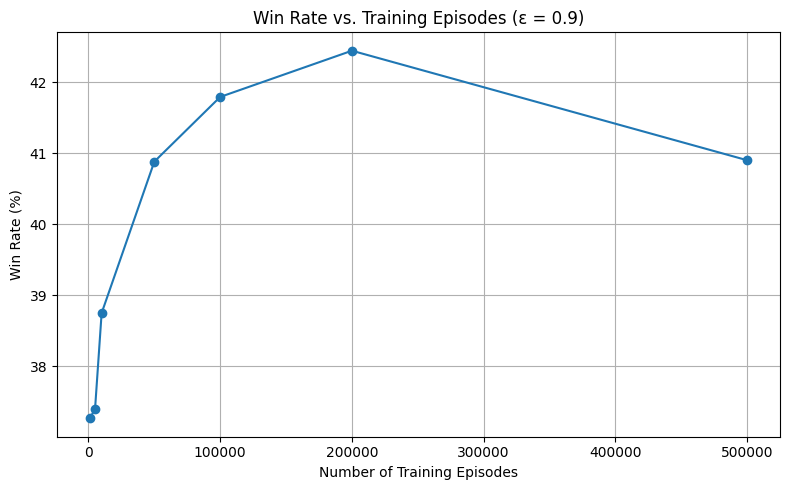

In [26]:
### Experiment 3: Plot win rate versus different numbers of training episodes (ε = 0.9)
episodes_list = [1000, 5000, 10000, 50000, 100000, 200000, 500000]
win_rates = []
print("\nStarting Experiment 3: Varying number of training episodes (ε = 0.9).")
for episodes in episodes_list:
    print(f"\nTraining with {episodes} episodes")
    Q_temp, _ = run_training(0.9, episodes, alpha, gamma)
    avg_reward, win_rate, _, _, _ = evaluate_policy(Q_temp, num_eval_episodes)
    win_rates.append(win_rate)
    print(f"  Evaluation: Avg. Reward = {avg_reward:.3f}, Win Rate = {win_rate:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(episodes_list, win_rates, marker='o', linestyle='-')
plt.title("Win Rate vs. Training Episodes (ε = 0.9)")
plt.xlabel("Number of Training Episodes")
plt.ylabel("Win Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()